# Задача 
Визуализировать KL-дивергенцию (в трех вариантах, KL(p1,p2), KL(p2,p1) и 0.5 KL(p1,p2) + 0.5 KL(p2,p1)) между распределением логитов ученика и учителя в задаче дистилляции знаний. Визуализация должна выглядеть как график (поверхность) от температуры и важности слагаемого дистилляции. Выборка: CIFAR-10 (для ученика при оптимизации взять только первые 10% выборки). Модель учителя: предобученный ResNet, модель ученика: сверточная с небольшим количеством слоев.

Импортируем нужные библиотеки

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import tqdm

from torchvision import transforms

Используем ImageNet нормализацию

In [3]:
mean = [x / 255 for x in [125.3, 123.0, 113.9]]
std = [x / 255 for x in [63.0, 62.1, 66.7]]

Загружаем данные

In [4]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [5]:
dataset = torch.utils.data.Subset(trainset, range(5000))

In [6]:
!wget https://raw.githubusercontent.com/passalis/pkth/master/cifar10/models/resnet18_cifar10.model

--2021-11-24 17:51:45--  https://raw.githubusercontent.com/passalis/pkth/master/cifar10/models/resnet18_cifar10.model
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44730527 (43M) [application/octet-stream]
Saving to: ‘resnet18_cifar10.model’

resnet18_cifar10.mo 100%[===================>]  42.66M   143MB/s    in 0.3s    

2021-11-24 17:51:46 (143 MB/s) - ‘resnet18_cifar10.model’ saved [44730527/44730527]



In [7]:
!git clone https://github.com/passalis/pkth.git

Cloning into 'pkth'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 52 (delta 10), reused 35 (delta 2), pack-reused 0
Unpacking objects: 100% (52/52), done.


In [8]:
import sys
sys.path.append('/content/pkth')

In [9]:
from models.resnet import ResNet18, ResNet, PreActBlock

In [10]:
teacher = ResNet18()
ch = torch.load('/content/resnet18_cifar10.model' )
teacher.load_state_dict(ch)
teacher.cuda()

dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)

In [11]:
val_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, shuffle=False, batch_size=64, num_workers=2)

Files already downloaded and verified


Реализуем функцию ошибки для задачи обучения с дистилляцией. Воспользуемся трюком, предложенным для улучшения оптимизации и домножим лосс дистилляции на $T^2$

In [12]:
def distillation(y, labels, teacher_scores, T, alpha):
    return nn.KLDivLoss()(F.log_softmax(y/T), F.softmax(teacher_scores/T)) * (T*T * 2.0 * alpha) + F.cross_entropy(y, labels) * (1. - alpha)

Выбираем сетку

In [17]:
alphas = torch.linspace(0.01, 0.99, 5)
Ts = torch.logspace(-2, 2, 5)

В качестве модели учителя берем ResNet18. В качестве модели студента берем ResNet18 с меньшим (в два раза) числом блоков.

In [ ]:
kls_st_te = []
kls_te_st = []
kls_mean = []

for alpha in alphas:
    for T in tqdm.tqdm(Ts):
        student = ResNet(PreActBlock, [1, 1, 1, 1], num_classes=10)
        student.cuda()

        opt = torch.optim.Adam(student.parameters(), lr=1e-3)
        for _ in range(15):
            correct = 0
            for (inputs, targets) in dataloader:
                opt.zero_grad()
                inputs, targets = inputs.cuda(), targets.cuda()

                teacher.eval()
                with torch.no_grad():
                    teacher_pred = teacher(inputs)
                
                student_pred = student(inputs)
                correct += (student_pred.argmax(1) == targets).detach().sum()

                loss = distillation(student_pred, targets, teacher_pred, T=10, alpha=0.5)
                loss.backward()
                opt.step()

            print(f'Train set: Accuracy: {100. * correct / len(dataset)}%)\n')

        teacher.eval()
        student.eval()

        st_preds = []
        te_preds = []
        with torch.no_grad():
            for (inputs, targets) in val_dataloader:
                inputs, targets = inputs.cuda(), targets.cuda()
                teacher_pred = teacher(inputs)
                student_pred = student(inputs)
                
                st_preds.append(teacher_pred)
                te_preds.append(student_pred)
        
        full_student = torch.cat(st_preds)
        full_teacher = torch.cat(te_preds)
        kl_st_te = nn.KLDivLoss()(F.log_softmax(full_student), F.softmax(full_teacher))
        kl_te_st = nn.KLDivLoss()(F.log_softmax(full_teacher), F.softmax(full_student))
        kl_mean = 0.5 * kl_te_st + 0.5 * kl_st_te

        kls_st_te.append(kl_st_te)
        kls_te_st.append(kl_te_st)
        kls_mean.append(kl_mean)

## Визуализация

In [22]:
import numpy as np

In [52]:
X, Y = np.meshgrid(alphas, Ts)

In [53]:
kls_mean_t = torch.stack(kls_mean).cpu().numpy()
kls_te_st_t = torch.stack(kls_te_st).cpu().numpy()
kls_st_te_t = torch.stack(kls_st_te).cpu().numpy()

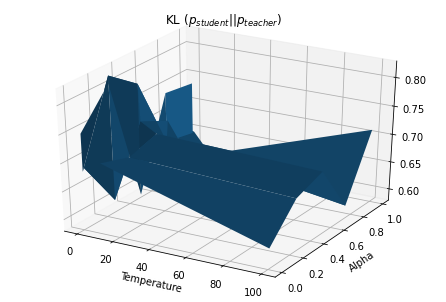

In [60]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(Y, X, kls_st_te_t.reshape(-1, 5))
plt.title('KL ($p_{student}||p_{teacher}$)')
plt.xlabel('Temperature')
plt.ylabel('Alpha')
plt.show()

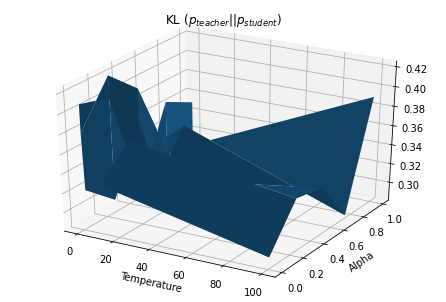

In [67]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(Y, X, kls_te_st_t.reshape(-1, 5))
plt.title('KL ($p_{teacher}||p_{student}$)')
plt.xlabel('Temperature')
plt.ylabel('Alpha')
plt.show()

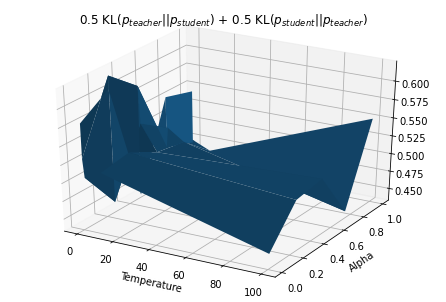

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(Y, X, kls_mean_t.reshape(-1, 5))
plt.title('0.5 KL($p_{teacher}||p_{student}$) + 0.5 KL($p_{student}||p_{teacher}$)')
plt.xlabel('Temperature')
plt.ylabel('Alpha')
plt.show()

Для более хороших графиков нужно более мелкая сетка 

Посмотрим зависимость полусуммы KL от $\alpha$ и $T^2$

No handles with labels found to put in legend.


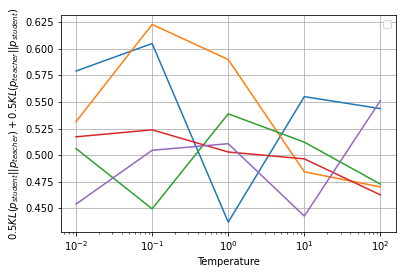

In [82]:
plt.plot(Ts, kls_mean_t.reshape(-1, 5).T)
plt.grid()
plt.xlabel('Temperature')
plt.ylabel('$0.5KL(p_{student}||p_{teacher}) + 0.5KL(p_{teacher}||p_{student})$')
plt.legend()
plt.semilogx()
plt.show()

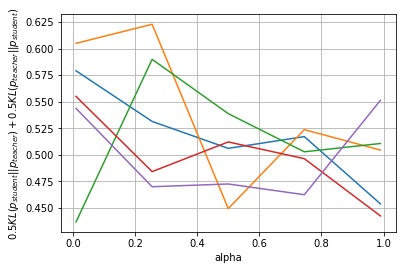

In [83]:
plt.plot(alphas, kls_mean_t.reshape(-1, 5))
plt.xlabel('alpha')
plt.ylabel('$0.5KL(p_{student}||p_{teacher}) + 0.5KL(p_{teacher}||p_{student})$')
plt.grid()
plt.show()

На больших температурах и больших альфах значение KL меньше, что соответствует теории.